<a href="https://colab.research.google.com/github/anwishn/ESAA/blob/main/1014_%EA%B3%BC%EC%A0%9C_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽 가이드 p.147-174

# 3단원. 평가



머신러닝의 프로세스 : 데이터 가공/변환 -> 모델 학습/예측 -> 평가
>머신러닝 모델은 여러 가지 방법으로 예측 성능 평가

* 회귀 : 실제값과 예측값의 오차 평균값에 기반 / 예측 오차를 가지고 정규화 수준 재가공하는 방법

ex) 오차에 절댓값 씌워 또는 오차의 제곱 값에 루트 씌워 평균 오차 구하는 방식 

* 분류 : 일반적으로는 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반 but 잘못된 평가 결과에 빠질 수도
 
 - 0과 1로 결정값이 한정되는 이진 분류의 성능 평가 지표

 - **정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC**
 - 결정 클래스 값 종류의 유형에 따라 이진분류와 멀티분류로 나뉘어

## 01.정확도(Accuracy)


---



>**정확도 = (예측 결과가 동일한 데이터 건수) / (전체 예측 데이터 건수)**

: 직관적으로 모델 예측 성능을 나타내는 평가 지표

: 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능 평가 x

ex) 타이타닉 예제 수행 결과 - 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황 발생

In [ ]:
# 정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지 확인
# 사이킷런의 BaseEstimator 클래스 상속받아 아무런 학습하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit()메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
  def predict(self,X):
    pred=np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    return pred

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [ ]:
from google.colab import files
uploaded = files.upload()

# 원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

Saving titanic_train.csv to titanic_train.csv


In [ ]:
# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는:{0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는:0.7877


=> 단순한 알고리즘으로 예측하더라도 정확도 결과 꽤 높은 수치 => 정확도를 평가 지표로 사용할 때는 매우 신중

* 특히 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 겨우, 적합한 평가 지표가 아니다!



* MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 확인

 - 사이킷런은 **load_digits()** API를 통해 MNIST 데이터 세트 제공

 - MNIST 데이터 세트는 0부터 9까지의 숫자 이미지의 픽셀 정보 o -> 숫자 Digit 예측하는 데 사용
    
   -> 레이블 값이 7인 것만 True, 나머지 값은 False(전체 데이터의 10%만 True, 나머지 90% False)인 불균형한 데이터 세트로 변형

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# 불균형한 데이터 세트와 Dummy Classifier 생성
class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros( (len(X), 1), dtype=bool )

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [ ]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


=> 모든 것을 0으로만 에측해도 정확도가 90% 

-> 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다 ! -> 여러 가지 분류 지표와 함께 적용하기

## 02. 오차 행렬



---



**오차행렬(=혼동행렬)** : 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

* 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지 나타내
 + 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative와 Positive로 분류
 + 위, 아래를 실제 클래스 값 기준으로 Negative와 Positive로 분류

* **TN, FP, FN, TP**는 예측 클래스와 실제 클래스의 Positive 결정값(값 1)와 Negative 결정 값(값 0)의 결합에 따라 결정돼
 + 앞 문자 Ture/False는 예측값과 실제값이 '같은가/틀린가' 의미
 + 뒤 문자 Negative/Positive는 예측 결과 값이 부정(0)/긍정(1) 의미


사이킷런은 오차 행렬 구하기 위해 **confusion_matrix()** API 제공

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)           # y_test는 실제 결과, fakepred는 예측 결과

array([[405,   0],
       [ 45,   0]])

=> TN : array[0,0]로 405, FP는 array[0,1]로 0, FN은 array[1,0]로 45, TP는 array[1,1]로 0

-> TP, TN, FP, TN 값을 조합해 성능 지표인 정확도, 정밀도, 재현율 값 알 수 있다

* 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)

* 일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 Positive를 설정해 1값 부여하고, 그렇지 않은 경우는 Negative로 0값 부여하는 경우 많아

-> Negative로 예측 정확도가 높아지는 경향 발생 -> 정확도 지표는 비대칭한 데이터 세트에서 수치적인 판단 오류(TN은 커지고 TP는 작아진다, FN와 FP는 작아져)

## 03. 정밀도와 재현율



---



정밀도와 재현율 : Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

>**정밀도 = TP / (FP + TP)** = 양성 예측도

  : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

  * 정밀도가 중요 지표인 경우 : 실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

  ex) 스팸 메일 여부를 판단하는 모델


>**재현율 = TP / (FN + TP)** = 민감도(Sensitivity) 또는 TPR(True Positive Rate)

  : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

  * 재현율이 중요 지표인 경우 : 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
  
  (보통 재현율이 정밀도보다 상대적으로 중요한 업무가 많음)

   ex) 암 판단 모델, 보험 사기와 같은 금융 사기 적발 모델 


* 재현율과 정밀도 모두 TP 높이는데 동일하게 초점 but 재현율은 FN 낮추는데, 정밀도는 FP 낮추는데 초점

   -> 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능 평가하는 데 적용

* 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치 얻는 것(한 평가 지표만 높고 낮은건 바람직 x)

사이킷런은 정밀도 계산 위해 **precision_score()**를, 재현율 계산을 위해 **recall_score()** API 제공

In [ ]:
# 정확도 뿐만 아니라 오차 행렬 및 정밀도, 재현율 모두 구해 예측 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
# 로지스틱 회귀 기반으로 분류 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### 정밀도/재현율 트레이드오프

**분류의 결정 임곗값 조정해 정밀도 또는 재현율의 수치 높일 수 있다**

but 정밀도,재현율은 상호 보완적인 평가 지표 -> 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다 = <u>정밀도/재현율의 트레이드오프</u>

개별 레이블별로 결정 확률 계산 -> 예측 데이터가 특정 레이블에 속하는지 계산 -> 예측 확률이 큰 레이블값으로 예측

* 일반적으로 이진 분류에서는 임곗값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정

사이킷런은 개별 데이터별로 예측 확률 반환하는 메서드인 **predict_proba()** 제공

: 학습이 완료된 사이킷런 Classifier 객체에서 호출 가능

: 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률 반환

: predict()와 유사하지만 반환결과가 예측 결과 클래스값이 아닌 예측 확률 결과

>* 입력 파라미터 : predict()메서드와 동일하게 테스트 피처 데이터 세트 입력
>* 반환값 : 개별 클래스의 예측 확률을 ndarray m x n (m : 입력 값의 레코드 수, n : 클래스 값 유형) 형태로 반환 
 + 각 열은 개별 클래스의 예측 확률(이진 분류에서 첫 번째 칼럼은 0 Negative의 확률, 두 번째 칼럼은 1 Positive의 확률)


In [ ]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


* predict() 메서드 : predict_proba() 메서드에 기반해 생성된 API

: predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API

=> 사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정 가능

* 사이킷런의 정밀도/재현율 트레이드오프 방식 구현 -> 사이킷런의 **Binarizer**클래스 이용

In [ ]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


* 사이킷런 predict()의 의사(pseudo) 코드

In [ ]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)        # 평가 지표 출력

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


=> predict()로 계산된 지표 값과 동일 -> predict()가 predict_proba()에 기반함을 알 수 있다

* 분류 결정 임곗값을 낮추면 평가 지표가 어떻게 변할까? 

In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


=> 임곗값을 낮추니 -> True값(Positive 예측값)이 많아져 -> 재현율 값이 올라가고 정밀도가 떨어졌다

In [ ]:
# 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표 조사
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


=> 임곗값이 0.45일 경우에 디폴트 0.5와 비교해 정확도는 동일, 정밀도는 약간 떨어졌으나 재현율 오름 

   -> 재현율 향상시키면서 다른 수치 어느정도 감소하는 희생해야한다면 임곗값 0.45가 가장 적당

사이킷런은 임곗값 변화에 따른 평가 지표 값 **precision_recall_curve()** API 제공

>* 입력 파타미터
>  + y_true : 실제 클래스값 배열 (배열 크기=[데이터 건수])
>  + probas_pred : Positive 칼럼의 예측 확률 배열 (배열 크기=[데이터 건수])
>* 반환 값
>  + 정밀도 : 임곗값별 정밀도 값을 배열로 반환
>  + 재현율 : 임곗값별 재현율 값을 배열로 반환

In [ ]:
# precision_recall_curve()이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구하기
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]    # 두 번째 칼럼 값에 해당하는 데이터 세트

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0],15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값: ',np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ',np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율: ',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임곗값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


=> 임곗값이 증가할수록 정밀도값은 동시에 높아지나 재현율 값은 낮아짐

* 정밀도와 재현율 곡선 시각화

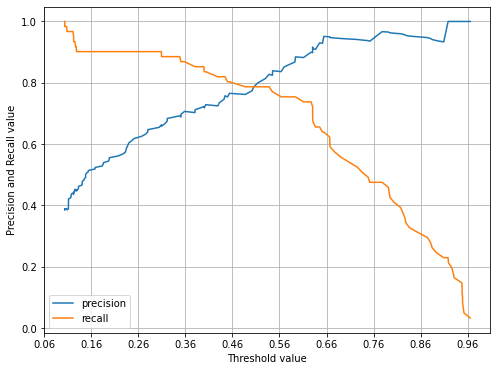

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

=> 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아진다

=> 임곗값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대 양상

=> 앞 예제의 로지스틱 회귀 기반의 타이타닉 생존자 에측 모델의 경우 임곗값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 모습 보여

### 정밀도와 재현율의 맹점


Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치 변경돼

-> 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 해

* 정밀도가 100%가 되는 방법

: 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측

정밀도=TP/(TP+FP)=100% <- FP=0, TP=1

* 재현율이 100%가 되는 방법

: 모든 경우를 Positive로 예측

재현율=TP/(TP+FN)=100% <- FN=0

=> 극단적인 수치 조작 가능

=> 분류가 정밀도, 재현율 중 하나에 상대적 중요도를 부여해 각 예측 상황에 맞는 분류 알고리즘 튜닝 가능 but 정밀도/재현율 중 하나만 강조 x

## 04. F1 스코어



---



**F1 스코어** : 정밀도와 재현율을 결합한 지표

* 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값

> **F1 = 2 / (1/recall + 1/precision) = 2 * (precision*recall) / (precision+recall)**

* 사이킷런은 **f1_score()** API 제공

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [ ]:
# 임곗값 0.4~0.6별로 정확도, 정밀도, 재현율, F1 스코어 알아보기
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


=> F1 스코어는 임곗값이 0.6일 때 가장 좋은 값 but 재현율이 크게 감소하고 있으니 주지

## 05. ROC 곡선과 AUC



---



>**ROC 곡선** (=수신자 판단 곡선)

: 머신러닝의 이진 분류 모델의 예측 성능 판단하는 중요한 평가 지표

: FPR(False Positive Rate)이 변화에 따른 TPR(True Positive Rate)의 변화를 나타낸 곡선

* TPR(True Positive Rate) 재현율 (= 민감도)

: 실제값 Positive(양성)가 정확히 예측돼야 하는 수준

TPR = TP / (FN + TP)

* TNR(True Negative Rate) 특이성

: 실제값 Negative(음성)가 정확히 예측돼야 하는 수준

TNR = TN / (FP + TN)

=> ROC 곡선의 X축 기준인 FPR = FP / (FP + TN) -> 1-TNR 또는 1-특이성

* ROC 곡선이 가운데 직선(ROC 곡선의 최저 값)에 가까울수록 성능이 떨어지는 것, 멀어질수록 성능이 뛰어난 것

>* 분류 결정 임곗값(Positive 예측값을 결정하는 확률 기준) / FPR = FP / (FP + TN)
 + 임곗값 = 1 -> FPR = 0
 + 임곗값 = 0 -> FPR = 1

=> 임곗값을 1부터 0까지 변화시키면서 FPR 값의 변화에 따른 TPR값 구하는 것이 ROC 곡선

(임곗값을 1부터 0까지 거꾸로 변화시키면서 구한 재현율 곡선의 형태와 비슷)

* 사이킷런은 ROC 곡선을 구하기 위해 **roc_curve()** API 제공

>* 입력 파라미터
 + y_true : 실제 클래스 값 array (array shape=[데이터 건수])
 + y_score : predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨. array shape=[n_samples]
>* 반환 값
 + fpr = fpr 값을 array로 반환
 + tpr = tpr 값을 array로 반환
 + thresholds : threshold 값 array


In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


=> 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR 점점 커지고 TPR은 가파르게 커짐

* FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화

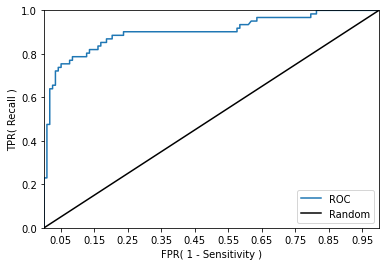

In [ ]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음.
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k-',label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1);plt.ylim(0,1)
  plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용

분류의 성능 지표로 사용되는 것은 = ROC 곡선 면적에 기반한 AUC 값으로 결정

>**AUC**(Area Under Curve) 값 : ROC 곡선 밑의 면적 구한 것

: 일반적으로 1에 가까울수록 좋은 수치

: 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치

: 보통의 분류는 0.5 이상의 AUC 값(<- 가운데 대각선 직선 = 0.5)

In [ ]:
# y_target, preds ??
'''
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도:",np.round(accuracy_score(y_target, preds),4))
print("정밀도:",np.round(precision_score(y_target, preds),4))
print("재현율:",np.round(recall_score(y_target, preds),4))
'''

NameError: ignored

In [ ]:
# 정확도, 정밀도, 재현율, F1 스코어, ROC AUC 값까지 출력
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
  F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))